In [43]:
import kagglehub

# Download Poultry Disease dataset
path = kagglehub.dataset_download("chandrashekarnatesh/poultry-diseases")

print("Dataset downloaded to:", path)


Dataset downloaded to: /kaggle/input/poultry-diseases


In [44]:
import os
import cv2
import numpy as np

def read_data(folder_path, categories, img_size=(224,224), samples_per_class=200):
    X = []
    y = []
    file_paths = []

    for label in categories:
        path = os.path.join(folder_path, label)
        images = os.listdir(path)[:samples_per_class]
        print(f"Loading {len(images)} images from {label}")

        for img_name in images:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
                file_paths.append(img_path)

    return np.array(X), np.array(y), file_paths


In [45]:

import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [46]:
categories = ["Coccidiosis", "Healthy", "New Castle Disease", "Salmonella"]

train_data_dir = "/root/.cache/kagglehub/datasets/chandrashekarnatesh/poultry-diseases/versions/3/data/data/train"
val_data_dir = "/root/.cache/kagglehub/datasets/chandrashekarnatesh/poultry-diseases/versions/3/data/data/val"
test_data_dir = "/root/.cache/kagglehub/datasets/chandrashekarnatesh/poultry-diseases/versions/3/data/data/test"

# Read 500 per class
train_X, train_y, train_paths = read_data(train_data_dir, categories)
val_X, val_y, val_paths = read_data(val_data_dir, categories)
test_X, test_y, test_paths = read_data(test_data_dir, categories)


Loading 200 images from Coccidiosis
Loading 200 images from Healthy
Loading 200 images from New Castle Disease
Loading 200 images from Salmonella
Loading 200 images from Coccidiosis
Loading 200 images from Healthy
Loading 200 images from New Castle Disease
Loading 200 images from Salmonella
Loading 200 images from Coccidiosis
Loading 200 images from Healthy
Loading 200 images from New Castle Disease
Loading 200 images from Salmonella


In [47]:
train_dir = "/root/.cache/kagglehub/datasets/chandrashekarnatesh/poultry-diseases/versions/3/data/data/train"
val_dir = "/root/.cache/kagglehub/datasets/chandrashekarnatesh/poultry-diseases/versions/3/data/data/val"
test_dir = "/root/.cache/kagglehub/datasets/chandrashekarnatesh/poultry-diseases/versions/3/data/data/test"


In [48]:

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Initialize ImageDataGenerator
gen = ImageDataGenerator(rescale=1./255)

In [49]:
# Normalize data
train_X = train_X / 255.0
val_X = val_X / 255.0
test_X = test_X / 255.0

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical

label_map = {name: idx for idx, name in enumerate(categories)}
train_y_cat = to_categorical([label_map[label] for label in train_y], num_classes=4)
val_y_cat = to_categorical([label_map[label] for label in val_y], num_classes=4)
test_y_cat = to_categorical([label_map[label] for label in test_y], num_classes=4)


In [50]:
train_gen = gen.flow_from_directory(train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, subset='training')


Found 400000 images belonging to 4 classes.


In [51]:
vgg = VGG16(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

# Freeze base layers
for layer in vgg.layers:
    layer.trainable = False

x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)


In [53]:
model.fit(
    train_X, train_y_cat,
    epochs=5,
    validation_data=(val_X, val_y_cat),
    batch_size=32
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.4199 - loss: 2.0555 - val_accuracy: 0.3713 - val_loss: 1.3772
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.5288 - loss: 1.5957 - val_accuracy: 0.4450 - val_loss: 1.3464
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.5580 - loss: 1.2685 - val_accuracy: 0.3925 - val_loss: 1.3293
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.5891 - loss: 1.2814 - val_accuracy: 0.3762 - val_loss: 1.2935
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.6072 - loss: 1.1419 - val_accuracy: 0.3850 - val_loss: 1.2877


In [54]:
from tensorflow.keras.applications import VGG19

base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_vgg19.trainable = False  # freeze base model


In [55]:
categories = ["Coccidiosis", "Healthy", "New Castle Disease", "Salmonella"]


In [56]:
from tensorflow.keras import layers, models
num_classes = 4

model_vgg19 = models.Sequential([
    base_vgg19,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')  # 4 classes
])


In [57]:
model_vgg19.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [58]:
history_vgg19 = model_vgg19.fit(
    train_X, train_y_cat,
    epochs=5,
    validation_data=(val_X, val_y_cat),
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.2984 - loss: 3.2368 - val_accuracy: 0.4675 - val_loss: 1.2578
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - accuracy: 0.4627 - loss: 1.2143 - val_accuracy: 0.5038 - val_loss: 1.1772
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.4871 - loss: 1.1433 - val_accuracy: 0.5213 - val_loss: 1.1714
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - accuracy: 0.5115 - loss: 1.0759 - val_accuracy: 0.5225 - val_loss: 1.1259
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - accuracy: 0.5328 - loss: 1.0199 - val_accuracy: 0.5387 - val_loss: 1.0961


In [59]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model


In [60]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


In [61]:
for layer in base_model.layers:
    layer.trainable = False



In [62]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)


In [63]:
model_resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)


Found 1948 validated image filenames belonging to 4 classes.
Found 632 validated image filenames belonging to 4 classes.


In [67]:
history_resnet = model_resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4903 - loss: 5.5861 - val_accuracy: 0.6630 - val_loss: 0.6222
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.6124 - loss: 0.9445 - val_accuracy: 0.7911 - val_loss: 0.4977
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6782 - loss: 0.7320 - val_accuracy: 0.8259 - val_loss: 0.4780
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.7300 - loss: 0.6691 - val_accuracy: 0.8370 - val_loss: 0.5022
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.7428 - loss: 0.6539 - val_accuracy: 0.8386 - val_loss: 0.4269


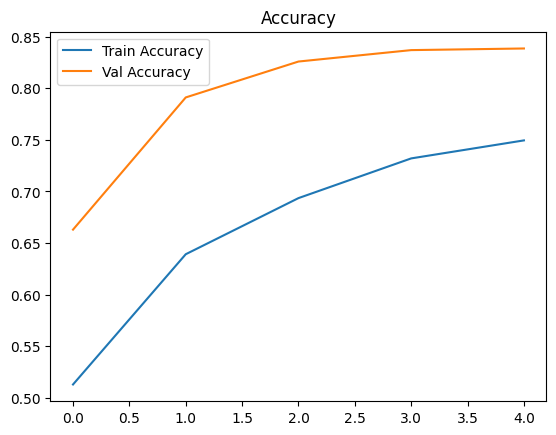

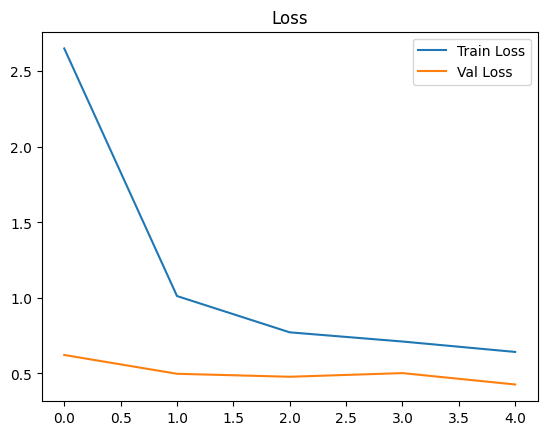

In [69]:
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()
